In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
    
pd.set_option("display.max_columns", None)

data_intermediate_dir = "data/intermediate/"

item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

## Predict consensus diagnosis on item-level data

In [85]:
# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

chosen_diag_cols = [ 
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression",
    "Diag: ADHD-Combined Type", #(very common non-learning)
    "Diag: Enuresis", #(rather objective - should be high)
    "Diag: Disruptive Mood Dysregulation Disorder" #(non-common non-learning)
] # Chosen diagnosis columns - learning disabilities + 3 extra for validation

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC columns


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
        
for diag_col in chosen_diag_cols:
    if item_lvl_w_imp[diag_col].sum() > 10: # Don't try to predict diagnosis if less than 10 positive instances in dataset
        output_col = diag_col
        
        # Split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=0)

        # Define models
        dt = DecisionTreeClassifier(random_state=42)
        rf = RandomForestClassifier(random_state=42)
        svc = svm.SVC(kernel='linear', C=1, random_state=42)
        svcr = svm.SVC(kernel='rbf', C=1, random_state=42)
        lr = LogisticRegression(solver="liblinear", random_state=42)
        
        # Standardize data
        dt_pipe = make_pipeline(StandardScaler(), dt)
        rf_pipe = make_pipeline(StandardScaler(), rf)
        svc_pipe = make_pipeline(StandardScaler(), svc)
        svcr_pipe = make_pipeline(StandardScaler(), svcr)
        lr_pipe = make_pipeline(StandardScaler(), lr)
        
        # Train models and check performance with stratified cross validation
        cv = StratifiedKFold(n_splits=3)
        
        dt_auc = cross_val_score(dt_pipe, X_train, y_train, cv=cv, scoring="roc_auc")
        rf_auc = cross_val_score(rf_pipe, X_train, y_train, cv=cv, scoring="roc_auc")
        svc_auc = cross_val_score(svc_pipe, X_train, y_train, cv=cv, scoring="roc_auc")
        svcr_auc = cross_val_score(svcr_pipe, X_train, y_train, cv=cv, scoring="roc_auc")
        lr_auc = cross_val_score(lr_pipe, X_train, y_train, cv=cv, scoring="roc_auc")
        
        print(output_col)
        print(dt_auc.mean(), rf_auc.mean(), svc_auc.mean(), svcr_auc.mean(), lr_auc.mean())

Diag: Specific Learning Disorder with Impairment in Reading
0.5337082104228122 0.5848133808587348 0.5823807767944936 0.5905338413634874 0.5836610947230416
Diag: Specific Learning Disorder with Impairment in Mathematics
0.5425694358466426 0.6291011514176056 0.6226940695802897 0.646516858569601 0.5994387355041063
Diag: Intellectual Disability-Mild
0.5407816482582838 0.7057941193455212 0.7891473358763079 0.803076553076553 0.6692562370132463
Diag: Borderline Intellectual Functioning
0.4852613794474259 0.6358260000120465 0.6121745782210898 0.6414495581937443 0.5870969684923173
Diag: Specific Learning Disorder with Impairment in Written Expression
0.4819132037851946 0.5494649616730743 0.5674174354061209 0.6046273445166079 0.5404908388478441
Diag: ADHD-Combined Type
0.6643081841473893 0.8535323288550023 0.8065579959485306 0.8594622678299504 0.8135221917692222
Diag: Enuresis
0.7095697848033412 0.827207703101463 0.7981594283085052 0.8424254226922868 0.8280057817777354
Diag: Disruptive Mood Dysr

In [86]:
# Check feature importance using the random forest model for Enuresis diagnosis

output_col = "Diag: Enuresis"

X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=0)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train[input_cols], y_train, test_size=0.3, random_state=0) # Split training set in training and validation set manually
rf.fit(X_train_train, y_train_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(feature_importances.sort_values(ascending=False))

DTS,DTS_01                        0.016439
PSI,PSI_PD                        0.014146
APQ_P,APQ_P_35                    0.011992
APQ_SR,APQ_SR_06                  0.011825
RBS,RBS_07                        0.011710
ARI_P,ARI_P_04                    0.010810
PSI,PSI_30                        0.010562
APQ_P,APQ_P_06                    0.010363
ARI_P,ARI_P_03                    0.010302
ESWAN,DMDD_9A                     0.009091
CBCL,CBCL_39                      0.008257
ESWAN,DMDD_9B                     0.008211
WHODAS_P,WHODAS_P_05              0.008180
ESWAN,DMDD_7B                     0.008084
APQ_P,APQ_P_27                    0.007897
DTS,DTS_03                        0.007269
CBCL,CBCL_20                      0.007205
SympChck,CSC_29P                  0.006647
CIS_P,CIS_P_07                    0.006646
PSI,PSI_09                        0.006516
MFQ_P,MFQ_P_32                    0.006395
CBCL,CBCL_51                      0.006334
CIS_P,CIS_P_05                    0.006299
SympChck,CS

In [120]:
from sklearn.model_selection import learning_curve 

cv = StratifiedKFold(n_splits=3)

output_col = "Diag: ADHD-Combined Type"
X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=0)

N, train_lc, val_lc = learning_curve(svm.SVC(kernel='rbf', C=1, random_state=42),
                                     X_train, y_train, cv=cv,
                                     train_sizes=np.linspace(0.1, 1, num=5))

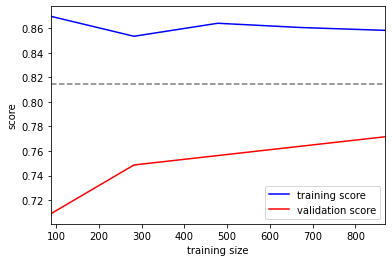

In [121]:
plt.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
plt.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
plt.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
             color='gray', linestyle='dashed')

ax = plt.gca()
#ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('training size')
ax.set_ylabel('score')
ax.legend(loc='best')